In [1]:
import slideio
from utils import get_test_images, display_driver_test_image_info 
from utils import show_images, show_image, get_driver_test_images
from utils import show_scene_info, show_scenes, show_volume
from IPython.display import display
import json
import pandas as pd
import random
import json
import matplotlib.pyplot as plt
import numpy as np

# Test images
For the future demonstration of the library, we will be utilizing some test images. Information regarding the images and the drivers required for image processing is stored in the *image.json* file. The helper utility *get_test_images* loads this image information into a list for convenient access and utilization during the demonstration.

In [2]:
images = get_driver_test_images('DCM')
display_driver_test_image_info(images, 'DCM', True)

Image Path,Driver,Options
./images/US-RGB-8-epicard,DCM,"['SINGLE-FRAME', 'JPEG']"
./images/OT-MONO2-8-colon.dcm,DCM,"['SINGLE-FRAME', 'NOT-COMPRESSED']"
./images/SC1_JLSN.dcm,DCM,"['SINGLE-FRAME', 'JLSN']"
./images/CT1_J2KI,DCM,"['SINGLE-FRAME', 'JPEG2000']"
./images/MR-MONO2-8-16x-heart,DCM,['Z-STACK']
./images/GSPS_Liver/DICOMDIR,DCM,"['DICOMDIR', 'Z-STACK']"
./images/BPAEC,DCM,['WSI']
./images/FluorCell_4,DCM,['WSI']
./images/FluorCell_4/3_0,DCM,"['WSI', 'SINGLE-LEVEL']"


# Compressions, modalities, data types
Slideio supports wide number of compressions including Jpeg 2000, modalities, and data types. The code sample below shows properties of some test images.

In [3]:
def extract_image_properties(slides):
    image_infos = []
    for image in slides:
        image_info = {}
        slide = slideio.open_slide(image['path'],"DCM")
        scene = slide.get_scene(0)
        image_info['Path'] = image['path']
        image_info['Num Channels'] = scene.num_channels
        image_info['Data Type'] = scene.get_channel_data_type(0)
        image_info['Compression'] = str(scene.compression).replace('Compression.','')
        image_info['Width'] = scene.size[0]
        image_info['Height'] = scene.size[1]
        image_info['Z Slices'] = scene.num_z_slices
        image_info['Z Frames'] = scene.num_t_frames
        modality = 'Unknown'
        raw_metadata = scene.get_raw_metadata()
        if raw_metadata and len(raw_metadata)>0:
            metadata = json.loads(raw_metadata)
            if '00080060' in metadata:
                modality = metadata['00080060']['Value'][0]
        image_info['Modality'] = modality
        image_infos.append(image_info)
    return pd.DataFrame(image_infos)

def extract_scenes(slides):
    return [slideio.open_slide(slide['path'],'DCM').get_scene(0) for slide in slides]

In [4]:
extract_image_properties(images)

,Path,Num Channels,Data Type,Compression,Width,Height,Z Slices,Z Frames,Modality
0,./images/US-RGB-8-epicard,3,uint8,Uncompressed,640,480,1,1,US
1,./images/OT-MONO2-8-colon.dcm,1,uint8,Uncompressed,512,512,1,1,OT
2,./images/SC1_JLSN.dcm,1,uint16,Jpeg,2048,2487,1,1,CT
3,./images/CT1_J2KI,1,int16,Jpeg2000,512,512,1,1,CT
4,./images/MR-MONO2-8-16x-heart,1,uint8,Uncompressed,256,256,16,1,MR
5,./images/GSPS_Liver/DICOMDIR,1,uint16,Uncompressed,480,480,25,1,MR
6,./images/BPAEC,1,uint8,Jpeg,12288,9216,1,1,Unknown
7,./images/FluorCell_4,1,uint8,Jpeg,11264,11264,1,1,Unknown
8,./images/FluorCell_4/3_0,1,uint8,Jpeg,11264,11264,1,1,Unknown


Code snipet below shows how pixel arrays can be extracted from single frame DICOM images

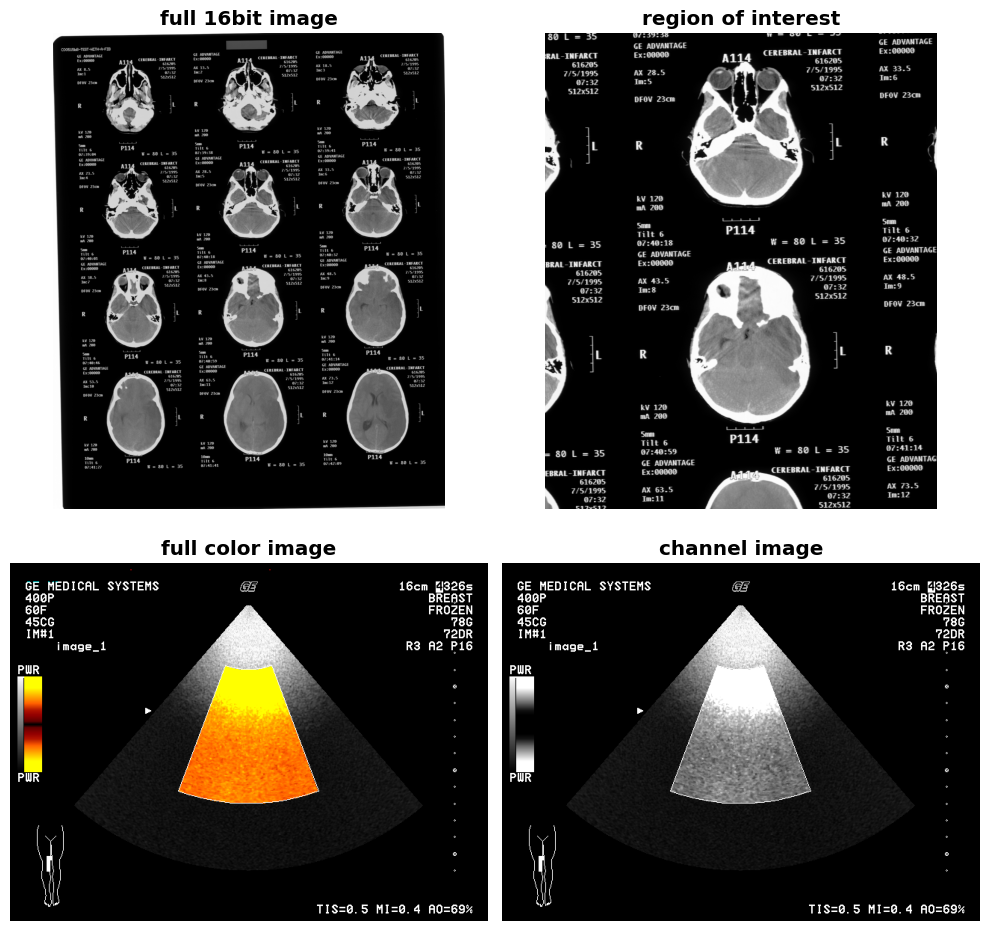

In [5]:
single_frame_images = [image for image in images if 'SINGLE-FRAME' in image['options']]
scenes = extract_scenes(single_frame_images)
scene = scenes[2]
rasters = []
raster_titles = []

# Read the full 16 bit image
full_image = scene.read_block() # read the whole image
rasters.append(full_image)
raster_titles.append("full 16bit image")

# Read a region of interest region.x = width/4, region.y = height/4, region.width = width/2, region.height = height/2
width, height = scene.size
roi_rect = (width//4,height//4,width//2,height//2)
roi_image = scene.read_block(roi_rect) # read region of interest defined by a rectangle
rasters.append(roi_image)
raster_titles.append("region of interest")

# Read a color image
scene = scenes[0]
full_image = scene.read_block() # read the whole image
rasters.append(full_image)
raster_titles.append("full color image")

# Read a single channel of the color image
channel_image = scene.read_block(channel_indices=[1]) # read a single channel of a color image
rasters.append(channel_image)
raster_titles.append("channel image")

# Show images
show_images(rasters, raster_titles, 500, columns=2)

Code snipet below iterates through the scenes and shows the single frame images of different modalities, compression and data types

Number of scenes: 4


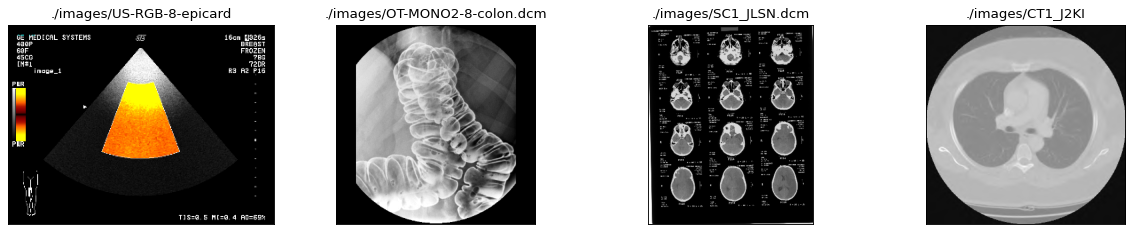

In [6]:
show_scenes(scenes, 4, (300,300))

# Metadata
Scene object exposes dicom tags as metadata. Method get_raw_metadata returns json representation of the dicom tags.
Specific tags can be accessed by tag keys. Tag 	(0010,0010) can be accessed by key 	"00100010".

In [7]:
single_frame_images = [image for image in images if 'SINGLE-FRAME' in image['options']]
scenes = extract_scenes(single_frame_images)
scene = scenes[0]
raw_metadata = scene.get_raw_metadata()
metadata = json.loads(raw_metadata)
modality = metadata['00080060']['Value'][0] # get modality: (0008,0060)
modality

'US'

In [8]:
metadata['00080060']

{'vr': 'CS', 'Value': ['US']}